In [1]:
sample_or_prod = False #True = sample, False = production

batch_size = 64 #ajust to suit memory capacity of hardware.

In [2]:
from theano.sandbox import cuda

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5110)


In [3]:
HOMEPATH = "/home/ubuntu/fastai/"

DATA_PATH = HOMEPATH+"data/Kaggle_dogs-vs-cats-redux-kernels-edition/"

MODEL_PATH = DATA_PATH+"models/"
RESULTS_PATH = DATA_PATH+"results/"


SAMPLE_DATA_PATH = DATA_PATH + "sample/"#choose this for testing or above for production
SAMPLE_TEST_PATH = SAMPLE_DATA_PATH+"test/"
SAMPLE_TRAIN_PATH = SAMPLE_DATA_PATH + "train/"
SAMPLE_VALID_PATH = SAMPLE_DATA_PATH + "valid/"


TEST_PATH = DATA_PATH+"test/"
TRAIN_PATH = DATA_PATH + "train/"
VALID_PATH = DATA_PATH + "valid/"


if sample_or_prod:
    WORKING_DATA  = SAMPLE_DATA_PATH
    WORKING_TEST  = SAMPLE_TEST_PATH
    WORKING_TRAIN = SAMPLE_TRAIN_PATH
    WORKING_VALID = SAMPLE_VALID_PATH
    s_or_p = "_sample_"
else:
    WORKING_DATA  = DATA_PATH
    WORKING_TEST  = TEST_PATH
    WORKING_TRAIN = TRAIN_PATH
    WORKING_VALID = VALID_PATH
    s_or_p = "_prod_"

    
print ("WORKING_DATA:", WORKING_DATA)
print ("WORKING_TEST:", WORKING_TEST)
print ("WORKING_TRAIN:", WORKING_TRAIN)
print ("WORKING_VALID:", WORKING_VALID)
print ("s_or_p:", s_or_p)


('WORKING_DATA:', '/home/ubuntu/fastai/data/Kaggle_dogs-vs-cats-redux-kernels-edition/')
('WORKING_TEST:', '/home/ubuntu/fastai/data/Kaggle_dogs-vs-cats-redux-kernels-edition/test/')
('WORKING_TRAIN:', '/home/ubuntu/fastai/data/Kaggle_dogs-vs-cats-redux-kernels-edition/train/')
('WORKING_VALID:', '/home/ubuntu/fastai/data/Kaggle_dogs-vs-cats-redux-kernels-edition/valid/')
('s_or_p:', '_prod_')


In [4]:
import os
from datetime import datetime


In [5]:
os.chdir(HOMEPATH)
print ("os.getcwd:", os.getcwd())
# Rather than importing everything manually, we'll make things easy
#   and load them all in utils.py, and just import them from there.
%matplotlib inline
import utils; reload(utils)
from utils import *

from vgg16 import Vgg16


('os.getcwd:', '/home/ubuntu/fastai')


Using Theano backend.


In [6]:
os.chdir(DATA_PATH)
print (os.getcwd())
!tree -d

/home/ubuntu/fastai/data/Kaggle_dogs-vs-cats-redux-kernels-edition
.
├── models
│   ├── train_convlayer_features_sample_.bc
│   │   ├── data
│   │   └── meta
│   ├── train_data_prod_.bc
│   │   ├── data
│   │   └── meta
│   ├── train_data_sample_.bc
│   │   ├── data
│   │   └── meta
│   ├── valid_convlayer_features_sample_.bc
│   │   ├── data
│   │   └── meta
│   ├── valid_data_prod_.bc
│   │   ├── data
│   │   └── meta
│   └── valid_data_sample_.bc
│       ├── data
│       └── meta
├── results
├── sample
│   ├── test
│   │   └── unknown
│   ├── train
│   │   ├── cat
│   │   └── dog
│   └── valid
│       ├── cat
│       └── dog
├── test
│   └── unknown
├── train
│   ├── cat
│   └── dog
└── valid
    ├── cat
    └── dog

37 directories


In [7]:
CATEGORIES = ['cat/', 'dog/']#nb: do not change order or trailing slash
UNKNOWN = 'unknown/'


In [8]:
DATA_DIR_LIST = [DATA_PATH, SAMPLE_DATA_PATH, SAMPLE_TEST_PATH, SAMPLE_TEST_PATH+UNKNOWN, SAMPLE_TRAIN_PATH, 
                 SAMPLE_VALID_PATH, TEST_PATH, TEST_PATH+UNKNOWN, TRAIN_PATH, VALID_PATH, MODEL_PATH, RESULTS_PATH]



for category in CATEGORIES:
    DATA_DIR_LIST.append(TRAIN_PATH+category)
    DATA_DIR_LIST.append(VALID_PATH+category)
    DATA_DIR_LIST.append(SAMPLE_TRAIN_PATH+category)
    DATA_DIR_LIST.append(SAMPLE_VALID_PATH+category)


#delete the variables we don't need to prevent accidental use.
del SAMPLE_DATA_PATH
del SAMPLE_TEST_PATH
del SAMPLE_TRAIN_PATH
del SAMPLE_VALID_PATH
del TEST_PATH
del TRAIN_PATH
del VALID_PATH


In [9]:
def dirFileList(dir_path):
    return [name for name in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, name))]

In [10]:
def listDirsFileCount(DATA_DIR_LIST):
    DATA_DIR_LIST = sorted(DATA_DIR_LIST)
    for dir_ in DATA_DIR_LIST:
        print dir_, len(dirFileList(dir_))


In [11]:
def showLayersInfo(model):
    print ("Number of layers : ", len(model.layers))
    count = 0
    for layer in model.layers:
        print count, type(layer), ", trainable:", layer.trainable
        print "input:", layer.input_shape, ", output:",layer.output_shape, "\n"
        count +=1

In [12]:
import bcolz
def save_array(fname, arr): c=bcolz.carray(arr, rootdir=fname, mode='w'); c.flush()
def load_array(fname): return bcolz.open(fname)[:]

In [13]:
def onehot(x): 
    return np.array(OneHotEncoder().fit_transform(x.reshape(-1,1)).todense())

In [14]:
def plot_history(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validate'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validate'], loc='upper left')
    plt.show()

In [15]:
listDirsFileCount(DATA_DIR_LIST)

/home/ubuntu/fastai/data/Kaggle_dogs-vs-cats-redux-kernels-edition/ 3
/home/ubuntu/fastai/data/Kaggle_dogs-vs-cats-redux-kernels-edition/models/ 9
/home/ubuntu/fastai/data/Kaggle_dogs-vs-cats-redux-kernels-edition/results/ 1
/home/ubuntu/fastai/data/Kaggle_dogs-vs-cats-redux-kernels-edition/sample/ 0
/home/ubuntu/fastai/data/Kaggle_dogs-vs-cats-redux-kernels-edition/sample/test/ 0
/home/ubuntu/fastai/data/Kaggle_dogs-vs-cats-redux-kernels-edition/sample/test/unknown/ 2500
/home/ubuntu/fastai/data/Kaggle_dogs-vs-cats-redux-kernels-edition/sample/train/ 0
/home/ubuntu/fastai/data/Kaggle_dogs-vs-cats-redux-kernels-edition/sample/train/cat/ 1750
/home/ubuntu/fastai/data/Kaggle_dogs-vs-cats-redux-kernels-edition/sample/train/dog/ 1750
/home/ubuntu/fastai/data/Kaggle_dogs-vs-cats-redux-kernels-edition/sample/valid/ 0
/home/ubuntu/fastai/data/Kaggle_dogs-vs-cats-redux-kernels-edition/sample/valid/cat/ 750
/home/ubuntu/fastai/data/Kaggle_dogs-vs-cats-redux-kernels-edition/sample/valid/dog/ 750

In [16]:
#utils:vgg_ft(out_dim)
#creates standard vgg16 model, pops last layer, sets all layers to non-trainable
#model.add(Dense(num, activation='softmax')) and model.compile
model = vgg_ft(2)

In [17]:
#'finetune3.h5' was generated in lesson 2
model.load_weights(MODEL_PATH+'finetune3'+s_or_p+'.h5')#NB: check s_or_p was set correctly in first cell

In [18]:
showLayersInfo(model)

('Number of layers : ', 38)
0 <class 'keras.layers.core.Lambda'> , trainable: False
input: (None, 3, 224, 224) , output: (None, 3, 224, 224) 

1 <class 'keras.layers.convolutional.ZeroPadding2D'> , trainable: False
input: (None, 3, 224, 224) , output: (None, 3, 226, 226) 

2 <class 'keras.layers.convolutional.Convolution2D'> , trainable: False
input: (None, 3, 226, 226) , output: (None, 64, 224, 224) 

3 <class 'keras.layers.convolutional.ZeroPadding2D'> , trainable: False
input: (None, 64, 224, 224) , output: (None, 64, 226, 226) 

4 <class 'keras.layers.convolutional.Convolution2D'> , trainable: False
input: (None, 64, 226, 226) , output: (None, 64, 224, 224) 

5 <class 'keras.layers.pooling.MaxPooling2D'> , trainable: False
input: (None, 64, 224, 224) , output: (None, 64, 112, 112) 

6 <class 'keras.layers.convolutional.ZeroPadding2D'> , trainable: False
input: (None, 64, 112, 112) , output: (None, 64, 114, 114) 

7 <class 'keras.layers.convolutional.Convolution2D'> , trainable: Fal

In [19]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 3, 224, 224)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 3, 226, 226)   0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 64, 224, 224)  1792        zeropadding2d_1[0][0]            
____________________________________________________________________________________________________
zeropadding2d_2 (ZeroPadding2D)  (None, 64, 226, 226)  0           convolution2d_1[0][0]            
___________________________________________________________________________________________

NB: same number and types of layers as at end of "Kaggle-cats-dogs-redux-2_load_data_build_model"  
NB: same 'Total params'  
nbb: different number of trainable params due to only last layer being trainable  
ie: previous  
Total params: 134,268,738  
Trainable params: 134,008,578  
Non-trainable params: 260,160  
this:  
Total params: 134,268,738  
Trainable params: 8,194  
Non-trainable params: 134,260,544  

In [20]:
layers = model.layers
print "len(layers):", len(layers)

len(layers): 38


In [21]:
last_conv_idx = [index for index,layer in enumerate(layers) 
                     if type(layer) is Convolution2D][-1]
print "last_conv_idx:", last_conv_idx
print type(layers[last_conv_idx])

last_conv_idx: 30
<class 'keras.layers.convolutional.Convolution2D'>


In [22]:
#split our model created from vgg_ft(p) into two sets of layers
#conv_layers = layers from start up to and including the last Convolution2D layer 
#fc_layers   = fc_layers layers to end

conv_layers = layers[:last_conv_idx+1]
print "len(conv_layers):", len(conv_layers)

conv_model = Sequential(conv_layers)
print "conv_model:", type(conv_model)

# Dense layers - also known as fully connected or 'FC' layers
fc_layers = layers[last_conv_idx+1:]
print "len(fc_layers):", len(fc_layers)


len(conv_layers): 31
conv_model: <class 'keras.models.Sequential'>
len(fc_layers): 7


In [23]:
conv_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 3, 224, 224)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 3, 226, 226)   0           lambda_1[0][0]                   
                                                                   lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 64, 224, 224)  1792        zeropadding2d_1[0][0]            
                                                                   zeropadding2d_1[1][0]            
___________________________________________________________________________________________

convolution2d_12 (Convolution2D) (None, 512, 14, 14)   2359808     zeropadding2d_12[0][0]           
                                                                   zeropadding2d_12[1][0]           
____________________________________________________________________________________________________
zeropadding2d_13 (ZeroPadding2D) (None, 512, 16, 16)   0           convolution2d_12[0][0]           
                                                                   convolution2d_12[1][0]           
____________________________________________________________________________________________________
convolution2d_13 (Convolution2D) (None, 512, 14, 14)   2359808     zeropadding2d_13[0][0]           
                                                                   zeropadding2d_13[1][0]           
Total params: 14,714,688
Trainable params: 0
Non-trainable params: 14,714,688
____________________________________________________________________________________________________


In [24]:
showLayersInfo(conv_model)

('Number of layers : ', 31)
0 <class 'keras.layers.core.Lambda'> , trainable: False
input: (None, 3, 224, 224) , output: (None, 3, 224, 224) 

1 <class 'keras.layers.convolutional.ZeroPadding2D'> , trainable: False
input: (None, 3, 224, 224) , output: (None, 3, 226, 226) 

2 <class 'keras.layers.convolutional.Convolution2D'> , trainable: False
input: (None, 3, 226, 226) , output: (None, 64, 224, 224) 

3 <class 'keras.layers.convolutional.ZeroPadding2D'> , trainable: False
input: (None, 64, 224, 224) , output: (None, 64, 226, 226) 

4 <class 'keras.layers.convolutional.Convolution2D'> , trainable: False
input: (None, 64, 226, 226) , output: (None, 64, 224, 224) 

5 <class 'keras.layers.pooling.MaxPooling2D'> , trainable: False
input: (None, 64, 224, 224) , output: (None, 64, 112, 112) 

6 <class 'keras.layers.convolutional.ZeroPadding2D'> , trainable: False
input: (None, 64, 112, 112) , output: (None, 64, 114, 114) 

7 <class 'keras.layers.convolutional.Convolution2D'> , trainable: Fal

In [25]:
Sequential(fc_layers).summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
maxpooling2d_5 (MaxPooling2D)    (None, 512, 7, 7)     0           convolution2d_13[0][0]           
____________________________________________________________________________________________________
flatten_1 (Flatten)              (None, 25088)         0           maxpooling2d_5[0][0]             
                                                                   maxpooling2d_5[0][0]             
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 4096)          102764544   flatten_1[0][0]                  
                                                                   flatten_1[1][0]                  
___________________________________________________________________________________________

In [26]:
showLayersInfo(Sequential(fc_layers))

('Number of layers : ', 7)
0 <class 'keras.layers.pooling.MaxPooling2D'> , trainable: False
input: (None, 512, 14, 14) , output: (None, 512, 7, 7) 

1 <class 'keras.layers.core.Flatten'> , trainable: False
input: (None, 512, 7, 7) , output: (None, 25088) 

2 <class 'keras.layers.core.Dense'> , trainable: False
input: (None, 25088) , output: (None, 4096) 

3 <class 'keras.layers.core.Dropout'> , trainable: False
input: (None, 4096) , output: (None, 4096) 

4 <class 'keras.layers.core.Dense'> , trainable: False
input: (None, 4096) , output: (None, 4096) 

5 <class 'keras.layers.core.Dropout'> , trainable: False
input: (None, 4096) , output: (None, 4096) 

6 <class 'keras.layers.core.Dense'> , trainable: True
input: (None, 4096) , output: (None, 2) 



In [27]:
print "WORKING_TRAIN:", WORKING_TRAIN
trn_batches = get_batches(WORKING_TRAIN, shuffle=False, batch_size=batch_size)
print "WORKING_VALID:", WORKING_VALID
val_batches = get_batches(WORKING_VALID, shuffle=False, batch_size=batch_size)
#produces keras.preprocessing.image.DirectoryIterator

WORKING_TRAIN: /home/ubuntu/fastai/data/Kaggle_dogs-vs-cats-redux-kernels-edition/train/
Found 17500 images belonging to 2 classes.
WORKING_VALID: /home/ubuntu/fastai/data/Kaggle_dogs-vs-cats-redux-kernels-edition/valid/
Found 7500 images belonging to 2 classes.


In [28]:
val_classes = val_batches.classes
trn_classes = trn_batches.classes
print "val_classes:", type(val_classes),val_classes.shape, "unique:", np.unique(val_classes)
print "trn_classes:", type(trn_classes),trn_classes.shape, "unique:", np.unique(trn_classes)

val_classes: <type 'numpy.ndarray'> (7500,) unique: [0 1]
trn_classes: <type 'numpy.ndarray'> (17500,) unique: [0 1]


In [29]:
trn_batches.class_indices#{'cats': 0, 'dogs': 1}

{'cat': 0, 'dog': 1}

In [30]:
print "val_batches", type(val_batches.nb_sample), val_batches.nb_sample
print "trn_batches", type(trn_batches.nb_sample), trn_batches.nb_sample

val_batches <type 'int'> 7500
trn_batches <type 'int'> 17500


In [31]:
val_labels = onehot(val_classes)
trn_labels = onehot(trn_classes)
print (type(val_labels), val_labels.shape, np.unique(val_labels))
print (type(trn_labels), trn_labels.shape, np.unique(trn_labels))
print ("val_labels[0:10]:",val_labels[0:10])

(<type 'numpy.ndarray'>, (7500, 2), array([ 0.,  1.]))
(<type 'numpy.ndarray'>, (17500, 2), array([ 0.,  1.]))
('val_labels[0:10]:', array([[ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.]]))


In [32]:
#recall : conv_model = vgg_16 Sequential up to the last Convolution2D layer.
#recall : val_batches = keras.preprocessing.image.DirectoryIterator using data from validation directory.
#https://keras.io/models/sequential/
#predict_generator(self, generator, steps=None, max_queue_size=10, workers=1, use_multiprocessing=False, verbose=0)
#Generates predictions for the input samples from a data generator.
#Returns : A Numpy array of predictions.
startTime= datetime.now()
print ("startTime:", startTime)
val_features = conv_model.predict_generator(val_batches, val_batches.nb_sample)
print "val_features:", val_features.shape
timeElapsed=datetime.now()-startTime
print 'Time elapsed (hh:mm:ss.ms) {}'.format(timeElapsed)
#NB: val_features.shape is this shape as it is the output from layer in model. ie: not final product.

('startTime:', datetime.datetime(2017, 12, 19, 11, 9, 33, 1093))
val_features: (7500, 512, 14, 14)
Time elapsed (hh:mm:ss.ms) 0:03:05.753812


In [33]:
startTime= datetime.now()
print ("startTime:", startTime)
trn_features = conv_model.predict_generator(trn_batches, trn_batches.nb_sample)
timeElapsed=datetime.now()-startTime
print('Time elapsed (hh:mm:ss.ms) {}'.format(timeElapsed))

('startTime:', datetime.datetime(2017, 12, 19, 11, 12, 38, 761826))
Time elapsed (hh:mm:ss.ms) 0:07:05.454037


In [34]:
save_array(MODEL_PATH + 'train_convlayer_features'+s_or_p+'.bc', trn_features)
save_array(MODEL_PATH + 'valid_convlayer_features'+s_or_p+'.bc', val_features)

In [35]:
print ("trn_features:", trn_features.shape)
print ("val_features:", val_features.shape)

('trn_features:', (17500, 512, 14, 14))
('val_features:', (7500, 512, 14, 14))


In [36]:
# Copy the weights from the pre-trained model.
# NB: Since we're removing dropout, we want to half the weights
def proc_wgts(layer): return [o/2 for o in layer.get_weights()]

In [37]:
# Such a finely tuned model needs to be updated very slowly!
#https://keras.io/optimizers/#rmsprop
#keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
#This optimizer is usually a good choice for recurrent neural networks.
opt = RMSprop(lr=0.00001, rho=0.7)

In [38]:
def get_fc_model():
    #creates model w layers:MaxPooling2D,  Flatten, Dropout, Dense, Dropout, Dense.
    model = Sequential([
        MaxPooling2D(input_shape=conv_layers[-1].output_shape[1:]),
        Flatten(),
        Dense(4096, activation='relu'),
        Dropout(0.),
        Dense(4096, activation='relu'),
        Dropout(0.),
        Dense(2, activation='softmax')
        ])

    #copy weights from fc_layers to model after div by 2
    for l1,l2 in zip(model.layers, fc_layers): 
        l1.set_weights(proc_wgts(l2))

    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [39]:
fc_model = get_fc_model()

In [40]:
fc_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
maxpooling2d_6 (MaxPooling2D)    (None, 512, 7, 7)     0           maxpooling2d_input_1[0][0]       
____________________________________________________________________________________________________
flatten_2 (Flatten)              (None, 25088)         0           maxpooling2d_6[0][0]             
____________________________________________________________________________________________________
dense_5 (Dense)                  (None, 4096)          102764544   flatten_2[0][0]                  
____________________________________________________________________________________________________
dropout_3 (Dropout)              (None, 4096)          0           dense_5[0][0]                    
___________________________________________________________________________________________

In [41]:
showLayersInfo(fc_model)

('Number of layers : ', 7)
0 <class 'keras.layers.pooling.MaxPooling2D'> , trainable: True
input: (None, 512, 14, 14) , output: (None, 512, 7, 7) 

1 <class 'keras.layers.core.Flatten'> , trainable: True
input: (None, 512, 7, 7) , output: (None, 25088) 

2 <class 'keras.layers.core.Dense'> , trainable: True
input: (None, 25088) , output: (None, 4096) 

3 <class 'keras.layers.core.Dropout'> , trainable: True
input: (None, 4096) , output: (None, 4096) 

4 <class 'keras.layers.core.Dense'> , trainable: True
input: (None, 4096) , output: (None, 4096) 

5 <class 'keras.layers.core.Dropout'> , trainable: True
input: (None, 4096) , output: (None, 4096) 

6 <class 'keras.layers.core.Dense'> , trainable: True
input: (None, 4096) , output: (None, 2) 



In [42]:
history = fc_model.fit(trn_features, trn_labels, nb_epoch=8, 
             batch_size=batch_size, validation_data=(val_features, val_labels))

Train on 17500 samples, validate on 7500 samples
Epoch 1/8
17500/17500 [==============================] - 29s - loss: 0.2937 - acc: 0.9794 - val_loss: 0.2355 - val_acc: 0.9833
Epoch 2/8
17500/17500 [==============================] - 29s - loss: 0.2137 - acc: 0.9850 - val_loss: 0.2461 - val_acc: 0.9825
Epoch 3/8
17500/17500 [==============================] - 29s - loss: 0.1702 - acc: 0.9881 - val_loss: 0.2215 - val_acc: 0.9844
Epoch 4/8
17500/17500 [==============================] - 29s - loss: 0.1487 - acc: 0.9899 - val_loss: 0.1986 - val_acc: 0.9864
Epoch 5/8
17500/17500 [==============================] - 29s - loss: 0.1296 - acc: 0.9913 - val_loss: 0.2036 - val_acc: 0.9859
Epoch 6/8
17500/17500 [==============================] - 29s - loss: 0.1129 - acc: 0.9923 - val_loss: 0.1823 - val_acc: 0.9871
Epoch 7/8
17500/17500 [==============================] - 29s - loss: 0.1016 - acc: 0.9934 - val_loss: 0.2155 - val_acc: 0.9845
Epoch 8/8
17500/17500 [==============================] - 29s -

['acc', 'loss', 'val_acc', 'val_loss']


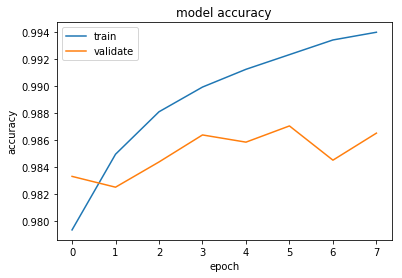

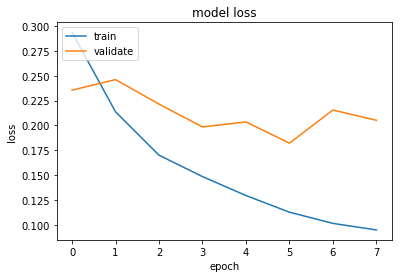

In [43]:
plot_history(history)

In [44]:
fc_model.save_weights(MODEL_PATH+'no_dropout'+s_or_p+'.h5')

In [45]:
#fc_model.load_weights(MODEL_PATH+'no_dropout.h5')

In [46]:
#may come back to use this imagegenerator later.
gen = image.ImageDataGenerator(rotation_range=10, 
                               width_shift_range=0.1, 
                               height_shift_range=0.1, 
                               shear_range=0.15, 
                               zoom_range=0.1, 
                               channel_shift_range=10., 
                               horizontal_flip=True)

In [47]:
#use this simpler ImageDataGenerator
gen = image.ImageDataGenerator(rotation_range=15, 
                               width_shift_range=0.1, 
                               height_shift_range=0.1, 
                               zoom_range=0.1, 
                               horizontal_flip=True)

In [48]:
trn_batches = get_batches(WORKING_TRAIN, gen, batch_size=batch_size)
# NB: We don't want to augment or shuffle the validation set
val_batches = get_batches(WORKING_VALID, shuffle=False, batch_size=batch_size)

Found 17500 images belonging to 2 classes.
Found 7500 images belonging to 2 classes.


In [49]:
fc_model = get_fc_model()

In [50]:
showLayersInfo(fc_model)

('Number of layers : ', 7)
0 <class 'keras.layers.pooling.MaxPooling2D'> , trainable: True
input: (None, 512, 14, 14) , output: (None, 512, 7, 7) 

1 <class 'keras.layers.core.Flatten'> , trainable: True
input: (None, 512, 7, 7) , output: (None, 25088) 

2 <class 'keras.layers.core.Dense'> , trainable: True
input: (None, 25088) , output: (None, 4096) 

3 <class 'keras.layers.core.Dropout'> , trainable: True
input: (None, 4096) , output: (None, 4096) 

4 <class 'keras.layers.core.Dense'> , trainable: True
input: (None, 4096) , output: (None, 4096) 

5 <class 'keras.layers.core.Dropout'> , trainable: True
input: (None, 4096) , output: (None, 4096) 

6 <class 'keras.layers.core.Dense'> , trainable: True
input: (None, 4096) , output: (None, 2) 



In [51]:
#set all layers in convolutional model to non-trainable, so data can flow through to new layers. added on top.
for layer in conv_model.layers: 
    layer.trainable = False
# Look how easy it is to connect two models together!
conv_model.add(fc_model)

In [52]:
showLayersInfo(conv_model)

('Number of layers : ', 32)
0 <class 'keras.layers.core.Lambda'> , trainable: False
input: (None, 3, 224, 224) , output: (None, 3, 224, 224) 

1 <class 'keras.layers.convolutional.ZeroPadding2D'> , trainable: False
input: (None, 3, 224, 224) , output: (None, 3, 226, 226) 

2 <class 'keras.layers.convolutional.Convolution2D'> , trainable: False
input: (None, 3, 226, 226) , output: (None, 64, 224, 224) 

3 <class 'keras.layers.convolutional.ZeroPadding2D'> , trainable: False
input: (None, 64, 224, 224) , output: (None, 64, 226, 226) 

4 <class 'keras.layers.convolutional.Convolution2D'> , trainable: False
input: (None, 64, 226, 226) , output: (None, 64, 224, 224) 

5 <class 'keras.layers.pooling.MaxPooling2D'> , trainable: False
input: (None, 64, 224, 224) , output: (None, 64, 112, 112) 

6 <class 'keras.layers.convolutional.ZeroPadding2D'> , trainable: False
input: (None, 64, 112, 112) , output: (None, 64, 114, 114) 

7 <class 'keras.layers.convolutional.Convolution2D'> , trainable: Fal

In [53]:
#use these to delete when re-running above cells.
#del conv_model
#del fc_model

In [54]:
conv_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [55]:
print ("start")
print("trn_batches.nb_sample:", trn_batches.nb_sample)
print("val_batches.nb_sample:", val_batches.nb_sample)
history = conv_model.fit_generator(trn_batches, 
                                   samples_per_epoch=trn_batches.nb_sample, 
                                   nb_epoch=8, 
                                   validation_data=val_batches, 
                                   nb_val_samples=val_batches.nb_sample)
print ("end")
#@6/8:loss: 0.2222 - acc: 0.9840 - val_loss: 0.2863 - val_acc: 0.9810

start
('trn_batches.nb_sample:', 17500)
('val_batches.nb_sample:', 7500)
Epoch 1/8
17500/17500 [==============================] - 628s - loss: 0.3545 - acc: 0.9745 - val_loss: 0.2287 - val_acc: 0.9837
Epoch 2/8
17500/17500 [==============================] - 627s - loss: 0.3347 - acc: 0.9769 - val_loss: 0.2343 - val_acc: 0.9835
Epoch 3/8
17500/17500 [==============================] - 627s - loss: 0.2862 - acc: 0.9798 - val_loss: 0.2052 - val_acc: 0.9859
Epoch 4/8
17500/17500 [==============================] - 627s - loss: 0.2661 - acc: 0.9808 - val_loss: 0.1732 - val_acc: 0.9877
Epoch 5/8
17500/17500 [==============================] - 627s - loss: 0.2249 - acc: 0.9839 - val_loss: 0.2254 - val_acc: 0.9849
Epoch 6/8
17500/17500 [==============================] - 627s - loss: 0.2168 - acc: 0.9846 - val_loss: 0.2169 - val_acc: 0.9853
Epoch 7/8
17500/17500 [==============================] - 627s - loss: 0.2131 - acc: 0.9849 - val_loss: 0.2080 - val_acc: 0.9851
Epoch 8/8
17500/17500 [========

['acc', 'loss', 'val_acc', 'val_loss']


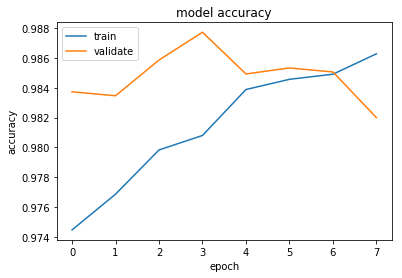

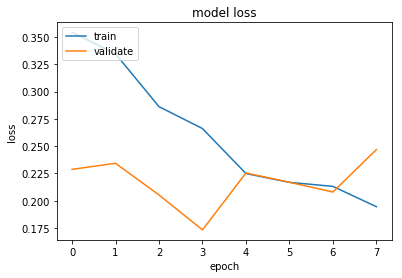

In [56]:
plot_history(history)

In [57]:
history = conv_model.fit_generator(trn_batches, 
                                   samples_per_epoch=trn_batches.nb_sample, 
                                   nb_epoch=3, 
                                   validation_data=val_batches, 
                                   nb_val_samples=val_batches.nb_sample)

Epoch 1/3
17500/17500 [==============================] - 628s - loss: 0.1944 - acc: 0.9859 - val_loss: 0.1965 - val_acc: 0.9864
Epoch 2/3
17500/17500 [==============================] - 627s - loss: 0.1772 - acc: 0.9871 - val_loss: 0.2068 - val_acc: 0.9860
Epoch 3/3
17500/17500 [==============================] - 627s - loss: 0.1879 - acc: 0.9868 - val_loss: 0.2061 - val_acc: 0.9852


['acc', 'loss', 'val_acc', 'val_loss']


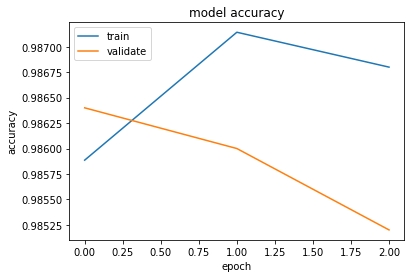

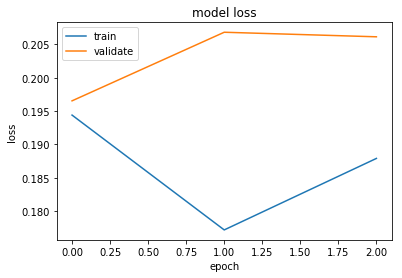

In [58]:
plot_history(history)

In [59]:
#conv_model.save_weights(MODEL_PATH + 'aug1.h5')
#conv_model.load_weights(MODEL_PATH + 'aug1.h5')

In [60]:
#conv_layers = list of first to last Convolution2D layers from vgg_16 model.
print "# of layers in conv_layers:", len(conv_layers)

# of layers in conv_layers: 31


In [61]:
print (conv_layers[-1].output_shape)
#get shape of last layer, show shape excluding 1st shape parameter. 
print (conv_layers[-1].output_shape[1:])

(None, 512, 14, 14)
(512, 14, 14)


In [62]:
def get_bn_layers(p):
    #create list of layers, use nominated dropout rate.
    #MaxPooling2D,Flatten,Dense,BatchNormalization,Dropout,Dense,BatchNormalization,Dropout,Dense
    return [
        MaxPooling2D(input_shape=conv_layers[-1].output_shape[1:]),
        Flatten(),
        Dense(4096, activation='relu'),
        BatchNormalization(),
        Dropout(p),
        Dense(4096, activation='relu'),
        BatchNormalization(),
        Dropout(p),
        Dense(1000, activation='softmax')
        ]

In [63]:
def load_fc_weights_from_vgg16bn(model):
    "Load weights for model from the dense layers of the Vgg16BN model."
    # See imagenet_batchnorm.ipynb for info on how the weights for
    # Vgg16BN can be generated from the standard Vgg16 weights.
    vgg16_bn = Vgg16BN()
    _, fc_layers = split_at(vgg16_bn.model, Convolution2D)
    #fc_layers = 
    print ("fc_layers:", type(fc_layers))
    copy_weights(fc_layers, model.layers)

In [64]:
p=0.6

In [65]:
bn_model = Sequential(get_bn_layers(0.6))
#MaxPooling2D,Flatten,Dense,BatchNormalization,Dropout,Dense,BatchNormalization,Dropout,Dense
print ("bn_model:", type(bn_model))

('bn_model:', <class 'keras.models.Sequential'>)


In [66]:
bn_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
maxpooling2d_8 (MaxPooling2D)    (None, 512, 7, 7)     0           maxpooling2d_input_3[0][0]       
____________________________________________________________________________________________________
flatten_4 (Flatten)              (None, 25088)         0           maxpooling2d_8[0][0]             
____________________________________________________________________________________________________
dense_11 (Dense)                 (None, 4096)          102764544   flatten_4[0][0]                  
____________________________________________________________________________________________________
batchnormalization_1 (BatchNorma (None, 4096)          16384       dense_11[0][0]                   
___________________________________________________________________________________________

In [67]:
showLayersInfo(bn_model)

('Number of layers : ', 9)
0 <class 'keras.layers.pooling.MaxPooling2D'> , trainable: True
input: (None, 512, 14, 14) , output: (None, 512, 7, 7) 

1 <class 'keras.layers.core.Flatten'> , trainable: True
input: (None, 512, 7, 7) , output: (None, 25088) 

2 <class 'keras.layers.core.Dense'> , trainable: True
input: (None, 25088) , output: (None, 4096) 

3 <class 'keras.layers.normalization.BatchNormalization'> , trainable: True
input: (None, 4096) , output: (None, 4096) 

4 <class 'keras.layers.core.Dropout'> , trainable: True
input: (None, 4096) , output: (None, 4096) 

5 <class 'keras.layers.core.Dense'> , trainable: True
input: (None, 4096) , output: (None, 4096) 

6 <class 'keras.layers.normalization.BatchNormalization'> , trainable: True
input: (None, 4096) , output: (None, 4096) 

7 <class 'keras.layers.core.Dropout'> , trainable: True
input: (None, 4096) , output: (None, 4096) 

8 <class 'keras.layers.core.Dense'> , trainable: True
input: (None, 4096) , output: (None, 1000) 



In [68]:
load_fc_weights_from_vgg16bn(bn_model)

('fc_layers:', <type 'list'>)


In [69]:
def proc_wgts(layer, prev_p, new_p):
    scal = (1-prev_p)/(1-new_p)
    print ("proc_wgts:scal:", scal)
    return [o*scal for o in layer.get_weights()]

In [70]:
for l in bn_model.layers: 
    if type(l)==Dense: 
        l.set_weights(proc_wgts(l, 0.5, 0.6))

('proc_wgts:scal:', 1.25)
('proc_wgts:scal:', 1.25)
('proc_wgts:scal:', 1.25)


In [71]:
last_layer = bn_model.layers[-1]
print type(last_layer)

<class 'keras.layers.core.Dense'>


In [72]:
print ("bn_model $ of layers:", len(bn_model.layers))
last_layer = bn_model.layers[-1]
print "bn_model.layers[-1]:", type(last_layer)
if len(bn_model.layers)==9:
    bn_model.pop()
    print "popped layer."
else:
    print "bn_model.layers!=9, not popped."
print ("bn_model $ of layers:", len(bn_model.layers))

('bn_model $ of layers:', 9)
bn_model.layers[-1]: <class 'keras.layers.core.Dense'>
popped layer.
('bn_model $ of layers:', 8)


In [73]:
#set all layers to non-trainable.
for layer in bn_model.layers: 
    layer.trainable=False

In [74]:
#re-add Dense layer to model.
#NB:2 = number of categories required ie: dog or cat.
bn_model.add(Dense(2,activation='softmax'))

In [75]:
showLayersInfo(bn_model)

('Number of layers : ', 9)
0 <class 'keras.layers.pooling.MaxPooling2D'> , trainable: False
input: (None, 512, 14, 14) , output: (None, 512, 7, 7) 

1 <class 'keras.layers.core.Flatten'> , trainable: False
input: (None, 512, 7, 7) , output: (None, 25088) 

2 <class 'keras.layers.core.Dense'> , trainable: False
input: (None, 25088) , output: (None, 4096) 

3 <class 'keras.layers.normalization.BatchNormalization'> , trainable: False
input: (None, 4096) , output: (None, 4096) 

4 <class 'keras.layers.core.Dropout'> , trainable: False
input: (None, 4096) , output: (None, 4096) 

5 <class 'keras.layers.core.Dense'> , trainable: False
input: (None, 4096) , output: (None, 4096) 

6 <class 'keras.layers.normalization.BatchNormalization'> , trainable: False
input: (None, 4096) , output: (None, 4096) 

7 <class 'keras.layers.core.Dropout'> , trainable: False
input: (None, 4096) , output: (None, 4096) 

8 <class 'keras.layers.core.Dense'> , trainable: True
input: (None, 4096) , output: (None, 2) 

In [76]:
bn_model.compile(Adam(), 'categorical_crossentropy', metrics=['accuracy'])

In [77]:
history = bn_model.fit(trn_features, trn_labels, nb_epoch=8, validation_data=(val_features, val_labels))
#loss: 0.2398 - acc: 0.9605 - val_loss: 0.1160 - val_acc: 0.9785
#loss: 0.2282 - acc: 0.9603 - val_loss: 0.0970 - val_acc: 0.9793

Train on 17500 samples, validate on 7500 samples
Epoch 1/8
17500/17500 [==============================] - 12s - loss: 0.3086 - acc: 0.9458 - val_loss: 0.0918 - val_acc: 0.9812
Epoch 2/8
17500/17500 [==============================] - 12s - loss: 0.2633 - acc: 0.9617 - val_loss: 0.1066 - val_acc: 0.9819
Epoch 3/8
17500/17500 [==============================] - 12s - loss: 0.3228 - acc: 0.9579 - val_loss: 0.0972 - val_acc: 0.9844
Epoch 4/8
17500/17500 [==============================] - 13s - loss: 0.3418 - acc: 0.9598 - val_loss: 0.1165 - val_acc: 0.9833
Epoch 5/8
17500/17500 [==============================] - 12s - loss: 0.3535 - acc: 0.9595 - val_loss: 0.1128 - val_acc: 0.9839
Epoch 6/8
17500/17500 [==============================] - 13s - loss: 0.3444 - acc: 0.9625 - val_loss: 0.1260 - val_acc: 0.9833
Epoch 7/8
17500/17500 [==============================] - 12s - loss: 0.3561 - acc: 0.9643 - val_loss: 0.1358 - val_acc: 0.9835
Epoch 8/8
17500/17500 [==============================] - 12s -

['acc', 'loss', 'val_acc', 'val_loss']


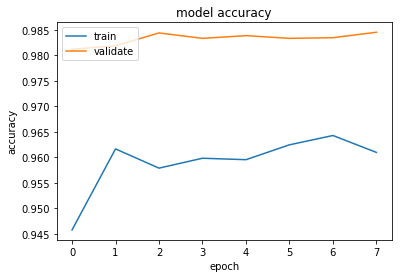

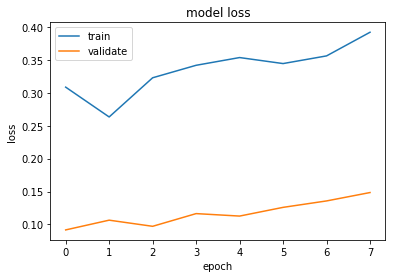

In [78]:
plot_history(history)

In [79]:
#bn_model.save_weights(MODEL_PATH+'bn.h5')


In [80]:
#bn_model.load_weights(MODEL_PATH+'bn.h5')

In [81]:
bn_layers = get_bn_layers(0.6)
print (len(bn_layers)), ", last layer:", type(bn_layers[-1])
#recall - get_bn_layers : creates list of layers with nominated dropout 
#MaxPooling2D,Flatten,Dense,BatchNormalization,Dropout,Dense,BatchNormalization,Dropout,Dense
#remove last layer (which is dense), replace with new layer with two categories. 
bn_layers.pop()
bn_layers.append(Dense(2,activation='softmax'))

9 , last layer: <class 'keras.layers.core.Dense'>


In [82]:
showLayersInfo(Sequential(bn_layers))

('Number of layers : ', 9)
0 <class 'keras.layers.pooling.MaxPooling2D'> , trainable: True
input: (None, 512, 14, 14) , output: (None, 512, 7, 7) 

1 <class 'keras.layers.core.Flatten'> , trainable: True
input: (None, 512, 7, 7) , output: (None, 25088) 

2 <class 'keras.layers.core.Dense'> , trainable: True
input: (None, 25088) , output: (None, 4096) 

3 <class 'keras.layers.normalization.BatchNormalization'> , trainable: True
input: (None, 4096) , output: (None, 4096) 

4 <class 'keras.layers.core.Dropout'> , trainable: True
input: (None, 4096) , output: (None, 4096) 

5 <class 'keras.layers.core.Dense'> , trainable: True
input: (None, 4096) , output: (None, 4096) 

6 <class 'keras.layers.normalization.BatchNormalization'> , trainable: True
input: (None, 4096) , output: (None, 4096) 

7 <class 'keras.layers.core.Dropout'> , trainable: True
input: (None, 4096) , output: (None, 4096) 

8 <class 'keras.layers.core.Dense'> , trainable: True
input: (None, 4096) , output: (None, 2) 



In [83]:
showLayersInfo(Sequential(conv_layers))

('Number of layers : ', 31)
0 <class 'keras.layers.core.Lambda'> , trainable: False
input: (None, 3, 224, 224) , output: (None, 3, 224, 224) 

1 <class 'keras.layers.convolutional.ZeroPadding2D'> , trainable: False
input: (None, 3, 224, 224) , output: (None, 3, 226, 226) 

2 <class 'keras.layers.convolutional.Convolution2D'> , trainable: False
input: (None, 3, 226, 226) , output: (None, 64, 224, 224) 

3 <class 'keras.layers.convolutional.ZeroPadding2D'> , trainable: False
input: (None, 64, 224, 224) , output: (None, 64, 226, 226) 

4 <class 'keras.layers.convolutional.Convolution2D'> , trainable: False
input: (None, 64, 226, 226) , output: (None, 64, 224, 224) 

5 <class 'keras.layers.pooling.MaxPooling2D'> , trainable: False
input: (None, 64, 224, 224) , output: (None, 64, 112, 112) 

6 <class 'keras.layers.convolutional.ZeroPadding2D'> , trainable: False
input: (None, 64, 112, 112) , output: (None, 64, 114, 114) 

7 <class 'keras.layers.convolutional.Convolution2D'> , trainable: Fal

In [84]:
#recall : conv_layers = list of first to last Convolution2D layers from vgg_16 model.
final_model = Sequential(conv_layers)
#set layers to non trainable
for layer in final_model.layers: 
    layer.trainable = False
#add layers to final_model to make it a complete vgg_16 set of layers.
for layer in bn_layers: 
    final_model.add(layer)
    
#final_model now has total 40 layers, first 31 layers are non trainable, last 9 layers are trainable.
#first 31 layers are stock vgg16, (layers from start up to and including the last Convolution2D layer)
# last 9 layers are MaxPooling2D,Flatten,Dense,BatchNormalization,Dropout,Dense,BatchNormalization,Dropout,Dense
# with dropout rate of 0.6 - created by get_bn_layers. 
#last layer set to Dense(2,activation='softmax') = 2 categories for dog/cat.
#starts with weights from lesson2.

In [85]:
showLayersInfo(final_model)

('Number of layers : ', 40)
0 <class 'keras.layers.core.Lambda'> , trainable: False
input: (None, 3, 224, 224) , output: (None, 3, 224, 224) 

1 <class 'keras.layers.convolutional.ZeroPadding2D'> , trainable: False
input: (None, 3, 224, 224) , output: (None, 3, 226, 226) 

2 <class 'keras.layers.convolutional.Convolution2D'> , trainable: False
input: (None, 3, 226, 226) , output: (None, 64, 224, 224) 

3 <class 'keras.layers.convolutional.ZeroPadding2D'> , trainable: False
input: (None, 64, 224, 224) , output: (None, 64, 226, 226) 

4 <class 'keras.layers.convolutional.Convolution2D'> , trainable: False
input: (None, 64, 226, 226) , output: (None, 64, 224, 224) 

5 <class 'keras.layers.pooling.MaxPooling2D'> , trainable: False
input: (None, 64, 224, 224) , output: (None, 64, 112, 112) 

6 <class 'keras.layers.convolutional.ZeroPadding2D'> , trainable: False
input: (None, 64, 112, 112) , output: (None, 64, 114, 114) 

7 <class 'keras.layers.convolutional.Convolution2D'> , trainable: Fal

In [86]:
#copy weights from bn_model.layers to bn_layers
#bn_model originally used weights from Vgg16BN
for l1,l2 in zip(bn_model.layers, bn_layers):
    l2.set_weights(l1.get_weights())

In [87]:
final_model.compile(optimizer=Adam(), 
                    loss='categorical_crossentropy', 
                    metrics=['accuracy'])

In [88]:
history = final_model.fit_generator(trn_batches, samples_per_epoch=trn_batches.nb_sample, nb_epoch=4, 
                        validation_data=val_batches, nb_val_samples=val_batches.nb_sample)
#loss: 0.6188 - acc: 0.9560 - val_loss: 0.3075 - val_acc: 0.9773

Epoch 1/4
17500/17500 [==============================] - 635s - loss: 1.0605 - acc: 0.9284 - val_loss: 0.5371 - val_acc: 0.9647
Epoch 2/4
17500/17500 [==============================] - 629s - loss: 0.7614 - acc: 0.9495 - val_loss: 0.4108 - val_acc: 0.9728
Epoch 3/4
17500/17500 [==============================] - 635s - loss: 0.6266 - acc: 0.9586 - val_loss: 0.3555 - val_acc: 0.9767
Epoch 4/4
17500/17500 [==============================] - 635s - loss: 0.6106 - acc: 0.9595 - val_loss: 0.4106 - val_acc: 0.9729


['acc', 'loss', 'val_acc', 'val_loss']


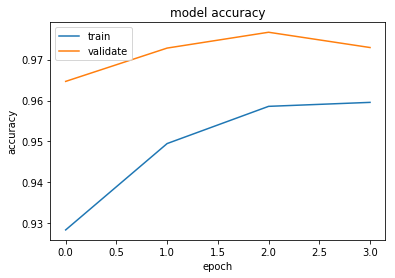

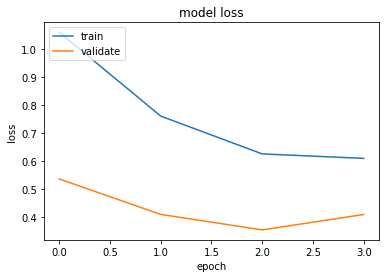

In [89]:
plot_history(history)

In [90]:
final_model.save_weights(MODEL_PATH + 'final_model_1'+s_or_p+'.h5')

In [91]:
history = final_model.fit_generator(trn_batches, samples_per_epoch=trn_batches.nb_sample, nb_epoch=8, 
                        validation_data=val_batches, nb_val_samples=val_batches.nb_sample)
print "final_model.optimizer.lr:", final_model.optimizer.lr

Epoch 1/8
17500/17500 [==============================] - 632s - loss: 0.6473 - acc: 0.9566 - val_loss: 0.3575 - val_acc: 0.9768
Epoch 2/8
17500/17500 [==============================] - 631s - loss: 0.6032 - acc: 0.9605 - val_loss: 0.3191 - val_acc: 0.9792
Epoch 3/8
17500/17500 [==============================] - 632s - loss: 0.5481 - acc: 0.9639 - val_loss: 0.3740 - val_acc: 0.9759
Epoch 4/8
17500/17500 [==============================] - 634s - loss: 0.5875 - acc: 0.9613 - val_loss: 0.3829 - val_acc: 0.9751
Epoch 5/8
17500/17500 [==============================] - 634s - loss: 0.5269 - acc: 0.9657 - val_loss: 0.3566 - val_acc: 0.9765
Epoch 6/8
17500/17500 [==============================] - 634s - loss: 0.5433 - acc: 0.9643 - val_loss: 0.3073 - val_acc: 0.9793
Epoch 7/8
17500/17500 [==============================] - 634s - loss: 0.5074 - acc: 0.9671 - val_loss: 0.3333 - val_acc: 0.9781
Epoch 8/8
17500/17500 [==============================] - 632s - loss: 0.5219 - acc: 0.9661 - val_loss: 0

['acc', 'loss', 'val_acc', 'val_loss']


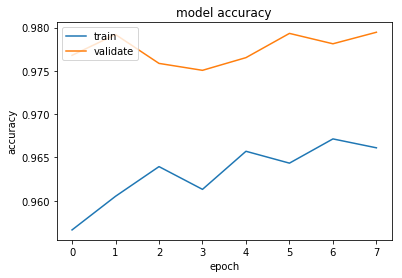

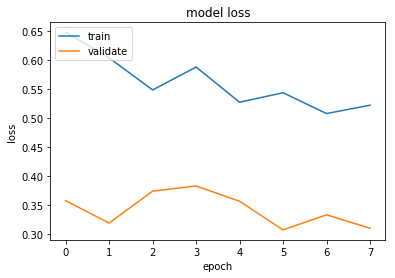

In [92]:
plot_history(history)

In [93]:
final_model.save_weights(MODEL_PATH + 'final_model_2'+s_or_p+'.h5')

In [94]:
final_model.optimizer.lr=0.001

In [95]:
print final_model.optimizer.lr

0.001


In [96]:
history = final_model.fit_generator(trn_batches, 
                                    samples_per_epoch=trn_batches.nb_sample, 
                                    nb_epoch=20,
                                    validation_data=val_batches, 
                                    nb_val_samples=val_batches.nb_sample)
#prev training : loss: 0.3764 - acc: 0.9720 - val_loss: 0.2855 - val_acc: 0.9787
#this training : 

Epoch 1/20
17500/17500 [==============================] - 631s - loss: 0.5031 - acc: 0.9670 - val_loss: 0.3147 - val_acc: 0.9789
Epoch 2/20
17500/17500 [==============================] - 633s - loss: 0.5928 - acc: 0.9621 - val_loss: 0.3802 - val_acc: 0.9751
Epoch 3/20
17500/17500 [==============================] - 632s - loss: 0.5234 - acc: 0.9664 - val_loss: 0.3553 - val_acc: 0.9768
Epoch 4/20
17500/17500 [==============================] - 633s - loss: 0.4456 - acc: 0.9710 - val_loss: 0.2639 - val_acc: 0.9832
Epoch 5/20
17500/17500 [==============================] - 632s - loss: 0.4716 - acc: 0.9694 - val_loss: 0.2837 - val_acc: 0.9821
Epoch 6/20
17500/17500 [==============================] - 630s - loss: 0.4863 - acc: 0.9685 - val_loss: 0.2886 - val_acc: 0.9812
Epoch 7/20
17500/17500 [==============================] - 629s - loss: 0.4866 - acc: 0.9687 - val_loss: 0.3315 - val_acc: 0.9788
Epoch 8/20
17500/17500 [==============================] - 628s - loss: 0.4222 - acc: 0.9729 - val

['acc', 'loss', 'val_acc', 'val_loss']


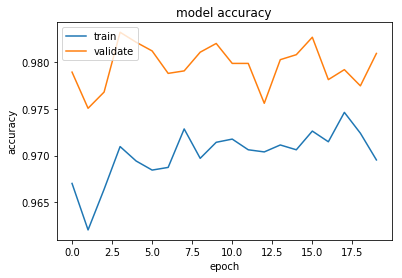

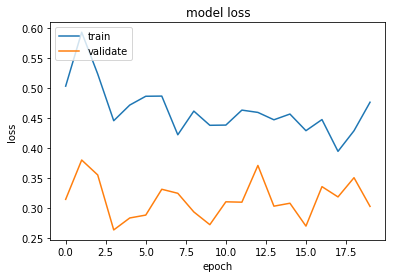

In [97]:
plot_history(history)

In [98]:
final_model.save_weights(MODEL_PATH + 'final_model_3'+s_or_p+'.h5')

In [99]:
MODEL_PATH

'/home/ubuntu/fastai/data/Kaggle_dogs-vs-cats-redux-kernels-edition/models/'

In [100]:
final_model.optimizer.lr=0.0001

In [102]:
history = final_model.fit_generator(trn_batches, samples_per_epoch=trn_batches.nb_sample, nb_epoch=20, 
                        validation_data=val_batches, nb_val_samples=val_batches.nb_sample)


Epoch 1/20
17500/17500 [==============================] - 636s - loss: 0.4640 - acc: 0.9705 - val_loss: 0.3160 - val_acc: 0.9799
Epoch 2/20
17500/17500 [==============================] - 632s - loss: 0.4295 - acc: 0.9724 - val_loss: 0.3157 - val_acc: 0.9793
Epoch 3/20
17500/17500 [==============================] - 723s - loss: 0.4253 - acc: 0.9726 - val_loss: 0.3157 - val_acc: 0.9795
Epoch 4/20
17500/17500 [==============================] - 919s - loss: 0.4125 - acc: 0.9739 - val_loss: 0.3132 - val_acc: 0.9800
Epoch 5/20
17500/17500 [==============================] - 820s - loss: 0.4191 - acc: 0.9735 - val_loss: 0.3140 - val_acc: 0.9801
Epoch 6/20
17500/17500 [==============================] - 647s - loss: 0.4194 - acc: 0.9734 - val_loss: 0.3029 - val_acc: 0.9807
Epoch 7/20
17500/17500 [==============================] - 647s - loss: 0.4092 - acc: 0.9739 - val_loss: 0.3139 - val_acc: 0.9800
Epoch 8/20
17500/17500 [==============================] - 646s - loss: 0.4331 - acc: 0.9722 - val

['acc', 'loss', 'val_acc', 'val_loss']


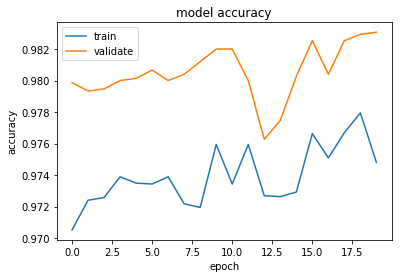

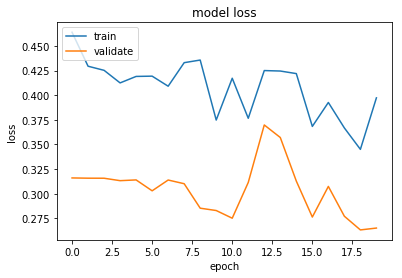

In [103]:
plot_history(history)

In [104]:
final_model.save_weights(MODEL_PATH + 'final_model_4_lr=p0001'+s_or_p+'.h5')

In [105]:
final_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 3, 224, 224)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 3, 226, 226)   0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 64, 224, 224)  1792        zeropadding2d_1[3][0]            
____________________________________________________________________________________________________
zeropadding2d_2 (ZeroPadding2D)  (None, 64, 226, 226)  0           convolution2d_1[3][0]            
___________________________________________________________________________________________

Total params: 134,301,506
Trainable params: 119,570,434
Non-trainable params: 14,731,072
____________________________________________________________________________________________________


In [106]:
showLayersInfo(final_model)

('Number of layers : ', 40)
0 <class 'keras.layers.core.Lambda'> , trainable: False
input: (None, 3, 224, 224) , output: (None, 3, 224, 224) 

1 <class 'keras.layers.convolutional.ZeroPadding2D'> , trainable: False
input: (None, 3, 224, 224) , output: (None, 3, 226, 226) 

2 <class 'keras.layers.convolutional.Convolution2D'> , trainable: False
input: (None, 3, 226, 226) , output: (None, 64, 224, 224) 

3 <class 'keras.layers.convolutional.ZeroPadding2D'> , trainable: False
input: (None, 64, 224, 224) , output: (None, 64, 226, 226) 

4 <class 'keras.layers.convolutional.Convolution2D'> , trainable: False
input: (None, 64, 226, 226) , output: (None, 64, 224, 224) 

5 <class 'keras.layers.pooling.MaxPooling2D'> , trainable: False
input: (None, 64, 224, 224) , output: (None, 64, 112, 112) 

6 <class 'keras.layers.convolutional.ZeroPadding2D'> , trainable: False
input: (None, 64, 112, 112) , output: (None, 64, 114, 114) 

7 <class 'keras.layers.convolutional.Convolution2D'> , trainable: Fal